In [11]:
import sys
sys.path.insert(1, '../')
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import cmath
from scipy.io import loadmat
from numpy.fft import fft, ifft
import random
import matplotlib as mpl
from attributedict.collections import AttributeDict



mpl.rcParams['figure.figsize'] = (12, 6) 
pi = np.pi

In [12]:

# %  VIDEO: Convolve real data with a Gaussian


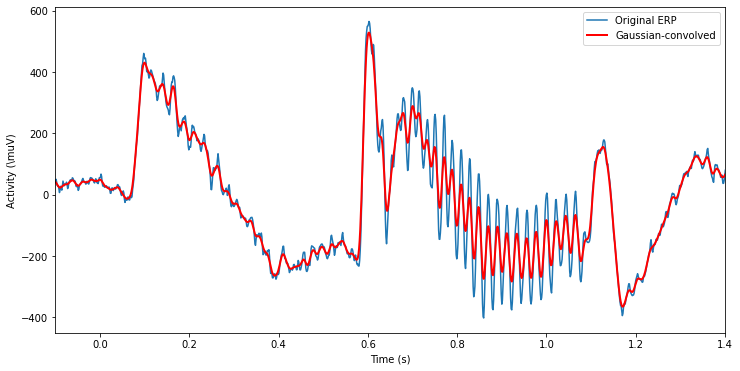

In [13]:
data = loadmat("../v1_laminar.mat")

srate = data['srate']
timevec = data['timevec'].T
# % signal will be ERP from channel 7
signal = np.mean(data['csd'][6, :, :], axis=1)

# % create a Gaussian
h = .01; # FWHM in seconds

gtime =  np.arange(-1,1,1/srate)
gaus = np.exp( -4*np.log(2)*gtime**2 / h**2 );
gaus = gaus/sum(gaus) #amplitude normalization


# %%%% run convolution
# % Step 1: N's of convolution
ndata = len(signal);
nkern = len(gaus);
nConv = ndata+nkern - 1# length of result of convolution
halfK = nkern//2


# FFTS
dataX = fft(signal, n=nConv)
kernX = fft(gaus, n=nConv)

# plt.plot(dataX)
# plt.plot(kernX)
# plt.show()

# multiply spectra
convresX = dataX * kernX

# inverse fft to get back to time domain
convres = ifft(convresX)

# cut off winds
convres = convres[halfK:-halfK+1]

plt.plot(timevec, signal, label='Original ERP')
plt.plot(timevec, convres.real,'r',linewidth=2, label='Gaussian-convolved')

plt.xlim([-.1, 1.4])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Activity (\muV)')
plt.show()

In [14]:
# %  VIDEO: Complex Morlet wavelets


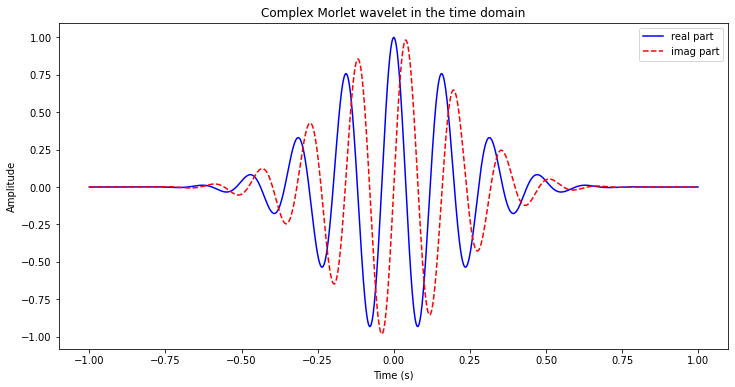

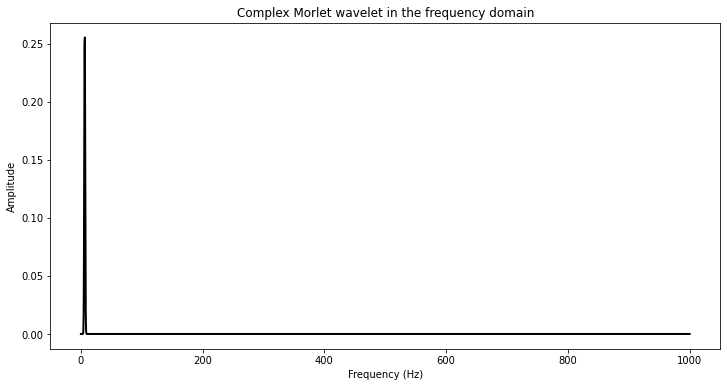

In [15]:
# % setup parameters
srate = 1000;         # in hz
time  = np.arange(-1,1,1/srate) # best practice is to have time=0 at the center of the wavelet
frex  = 2*pi;         # frequency of wavelet, in Hz

# % create sine wave
sine_wave = np.exp( 1j*2*pi*frex*time ) # hmmmm

# plt.plot(sine_wave.real)
# plt.plot(sine_wave.imag, 'r--')
# plt.show()

# % create Gaussian window
fwhm = .5; # width of the Gaussian in seconds
gaus_win = np.exp( -4*np.log(2)*time**2 / fwhm**2 )

# % now create Morlet wavelet
cmw = sine_wave * gaus_win

plt.plot(time, cmw.real,'b', label='real part')
plt.plot(time, cmw.imag,'r--', label='imag part')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Complex Morlet wavelet in the time domain')
plt.show()

# %% complex Morlet wavelet in the frequency domain

pnts = len(time)

mwX = abs(fft( cmw )/pnts);
hz  = np.linspace(0,srate,pnts);

plt.plot(hz,mwX,'k',linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Complex Morlet wavelet in the frequency domain')
plt.show()

In [16]:
# %  VIDEO: Complex Morlet wavelet convolution


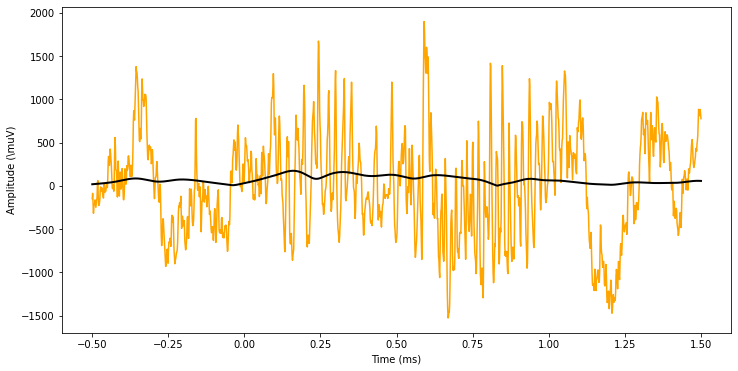

In [32]:
# % extract a bit of data for convenience
data_ = data["csd"][5,:,9]

# % create a complex Morlet wavelet
time = np.arange(2*srate)/srate
time = time - np.mean(time); # note the alternative method for creating centered time vector 
frex = 45; # frequency of wavelet, in Hz

# % create Gaussian window
s = 7 / (2*pi*frex); # using num-cycles formula
cmw  = np.exp(1j*2*pi*frex*time) * np.exp( (-time**2) / ((2*s)**2) )


# N's of convolution
nData = len(timevec)
nKern = len(cmw)
nConv = nData + nKern - 1
halfK = nKern // 2

# FFTs
dataX = fft(data_, nConv)
kernX = fft(cmw, nConv)

# normalize the wavelet
kernX = kernX / max(kernX)

convresX = dataX * kernX
convres = ifft(convresX)

# cut off wings
convres = convres[halfK:-halfK+1]

hz = np.linspace(0, srate/2, nConv//2+1)

plt.plot(timevec, data_,'orange', label="LFP data")
plt.plot(timevec, abs(convres), 'k',linewidth=2, label='Convulted Data')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (\muV)')
plt.show()

In [27]:
# % VIDEO: A full time-frequency power plot!
# % 
# % 

# %%% Take a deep breath: You're about to make your first time-frequency
# %   power plot!

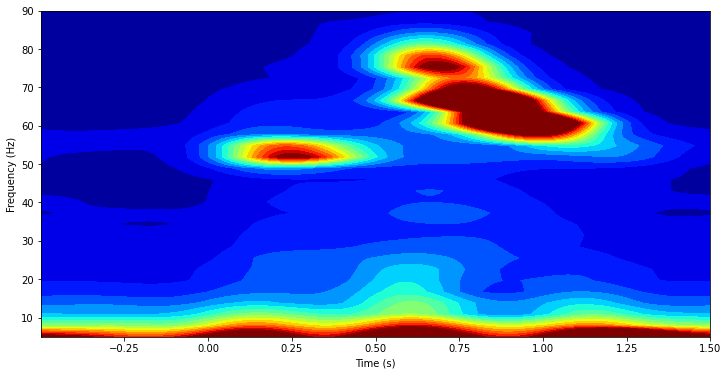

In [28]:
data_ = data["csd"][5,:,:]
# % reshape the data to be 1D
dataR = np.reshape(data_, -1, order='F')

ndata = len(dataR); # note the different variable name!
nkern = len(time);
nConv = ndata + nkern - 1;
halfK = nkern//2

dataX = fft(dataR, nConv)

# % frequency parameters
min_freq =  5; # in Hz
max_freq = 90; # in HZ
num_freq = 30; # in count

frex = np.linspace(min_freq,max_freq,num_freq);

# % initialize TF matrix
tf = np.zeros((num_freq,len(timevec)));

# % IMPORTANT! I'm omitting a few steps of convolution 
# %            that are already computed above.

for fi in range(num_freq):
    
#     % create wavelet
    cmw  = np.exp(1j*2*pi*frex[fi]*time) * np.exp( -4*np.log(2)*time**2 / .3**2 );
    
    cmwX = fft(cmw,nConv);
    cmwX = cmwX/max(cmwX);
    
#     % the rest of convolution
    as_ = ifft( dataX*cmwX );
    as_ = as_[halfK:-halfK+1];
    as_ = np.reshape(as_,data_.shape, order='F');
    
#     % extract power
    aspow = abs(as_) ** 2
    
#     % average over trials and put in matrix
    tf[fi,:] = np.mean(aspow,1)
    
plt.contourf(np.squeeze(timevec),frex,tf,40, vmin=0, vmax=10000, cmap="jet")
# set(gca,'clim',[0 1]*10000,'xlim',[-.1 1.4])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()